In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pathlib
from tqdm import tqdm
from abc import ABCMeta, abstractmethod

I have downloaded the dataset locally and mentioned paths below. Since dataset is huge (~30 GB), I am not pushing it to the repository. You can put the `data` dir inside dataset adjacent to this jupyter notebook in order to run it successfully.

In [2]:
train_data_dir = 'data/train'
test_data_dir = 'data/test'
train_data_path = pathlib.Path(train_data_dir)
test_data_path = pathlib.Path(test_data_dir)

Below are all the classes given for tissue samples in `train` and `test` dataset.

In [3]:
tissue_classes = [
    'spleen',
    'skin_1',
    'skin_2',
    'pancreas',
    'lymph_node',
    'small_intestine',
    'endometrium_1',
    'endometrium_2',
    'liver',
    'kidney',
    'lung',
    'colon'
]

Let us display an example image from each of the `12` classes of tissues in our dataset.

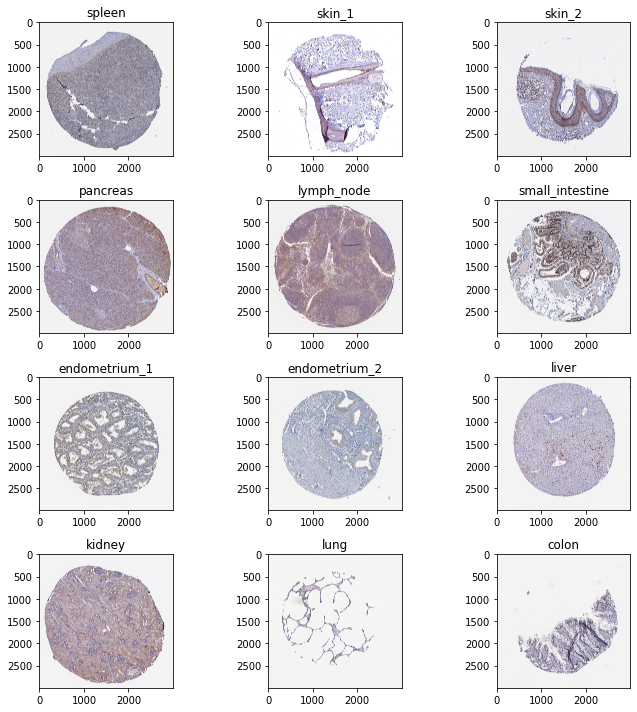

In [4]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

counter = 0
for row in ax:
    for col in row:
        images = list(train_data_path.glob(tissue_classes[counter] + '/*'))
        image = np.array(PIL.Image.open(str(images[0])))
        col.set_title(tissue_classes[counter])
        col.imshow(image)
        counter += 1

fig.tight_layout()
plt.show()

From dataset, we have **1119** unique images for **training** and **600** unique images for **testing** data.  

Since we are working with very large dataset, it is not advisable to load all the data at once. It is not possible to do that since the data is huge. That is why, we have created data generator which will generate training/testing examples on demand. It will only generate a batch of examples at a time.  

Below class is the custom data generator we have created in order to ingest images into ML pipeline.

In [43]:
class TissueDataGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                 data_dir,
                 batch_size,
                 class_labels,
                 img_height=128,
                 img_width=128,
                 img_channels=3,
                 preprocess_func=None,
                 shuffle=True):
        self.file_ds = tf.data.Dataset.list_files(str(data_dir + '/*/*'))
        self.batch_size = batch_size
        self.class_labels = class_labels
        self.n_classes = len(class_labels)
        self.img_size = (img_height, img_width)
        self.img_n_channels = img_channels
        self.shuffle = shuffle
        self.preprocess_func = preprocess_func
        self.label_mapping = self.find_label_mappings()
        self.labeled_ds = self.file_ds.map(lambda f: tf.py_function(func=self.process_example,
                                                                    inp=[f],
                                                                    Tout=[tf.float32, tf.int32]))
        self.labeled_ds = self.labeled_ds.batch(self.batch_size)
        self.on_epoch_end()
    
    def find_label_mappings(self):
        mp = {}
        for i, label in enumerate(self.class_labels):
            mp[label] = i
        return mp
    
    def process_example(self, file_path):
        label = tf.strings.split(file_path, os.sep)[-2]
        label_map = self.label_mapping[str(label.numpy().decode('utf-8'))]
        label_encode = tf.keras.utils.to_categorical(label_map, self.n_classes)
        image = np.array(PIL.Image.open(str(file_path.numpy().decode('utf-8'))))
        image = tf.image.resize(image, self.img_size)
        if self.preprocess_func is not None:
            image = self.preprocess_func(image)
        return image, label_encode
    
    def __getitem__(self, index):
        'Generate one batch of data'
        batch = next(self.iterator, None)
        if batch is None:
            self.on_epoch_end()
            batch = next(self.iterator)
        return batch
    
    def on_epoch_end(self):
        self.iterator = iter(self.labeled_ds)
    
    def __len__(self):
        return len(self.file_ds) // self.batch_size

During our research of finding best model for image classification, we usually experiment on various different kinds of models. Because of that, we usually rewrite some of the code redundantly. To prevent that, we have created abstract model class below. Whatever models we want to experiment on can inherit this class to get access to some of the common features we will use for all the model classes like compiling & training model, testing model, plotting metrics etc.

In [15]:
class ModifiedModel:
    __metaclass__ = ABCMeta
    
    def __init__(self,
                 input_shape,
                 num_classes,
                 optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'],
                 verbose=True):
        if not isinstance(input_shape, list) and not isinstance(input_shape, tuple):
            raise TypeError('input_shape must be of type list or tuple.')
        input_shape = tuple(input_shape)
        if len(input_shape) != 3:
            raise TypeError('input_shape must contain exactly 3 dimensions.')
        
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.verbose = verbose
        self.history = None
        self.model = None
    
    @abstractmethod
    def build_model(self):
        pass
    
    def compile_model(self, **kwargs):
        self.raise_if_not_built()
        self.model.compile(optimizer=self.optimizer,
                           loss=self.loss,
                           metrics=self.metrics, **kwargs)
    
    def raise_if_not_built(self):
        if self.model is None:
            raise ValueError('object of model class has not created instance yet.')
    
    def train(self, train_generator, epochs, **kwargs):
        self.raise_if_not_built()
        self.history = self.model.fit(train_generator, epochs=epochs, **kwargs)
    
    def test(self, test_generator, **kwargs):
        self.raise_if_not_built()
        return self.model.evaluate(test_generator, **kwargs)
    
    def plot_metrics(self):
        if self.history is None:
            raise ValueError('model must be trained to generate metric plot.')
        if 'loss' not in self.history.history:
            raise ValueError('history must contain loss information.')
        if 'accuracy' not in self.history.history:
            raise ValueError('history must contain accuracy information')
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        attrs = ['loss', 'accuracy']
        counter = 0
        for col in ax:
            info = self.history.history[attrs[counter]]
            col.plot(range(len(info)), info)
            col.set_title(attrs[counter])
            col.set_xlabel('Epochs')
            col.set_ylabel(attrs[counter])
            counter += 1
        fig.tight_layout()
        plt.show()
    
    def display_score(self, score):
        if len(score) < 2:
            raise ValueError('score must have atleast 2 values')
        print('Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Below are some of the parameters which will be common across all the experiments and that is why we have decided to initialize them at the top and all other experiments will consume these three parameters.

**Note:** We haven't fixed shape of input images because the input image shape may differ based on the model we experiment on. Also, We haven't used original dimension `(3000, 3000, 3)` because of computational power restrictions. We are using smaller shapes of images as input as per the model requirements

In [13]:
batch_size = 4
num_channels = 3
epochs = 15

## Training Custom CNN model for image classification

Custom model inherits the `ModifiedModel` class defined above. We have used multiple Conv - Max pooling blocks following softmax output. The input images resized to shape `(128, 128, 3)`.

In [14]:
custom_img_height = 128
custom_img_width = 128

custom_train_gen = TissueDataGenerator(train_data_dir,
                                       batch_size=batch_size,
                                       class_labels=tissue_classes,
                                       img_height=custom_img_height,
                                       img_width=custom_img_width)
custom_test_gen = TissueDataGenerator(test_data_dir,
                                      batch_size=batch_size,
                                      class_labels=tissue_classes,
                                      img_height=custom_img_height,
                                      img_width=custom_img_width)

In [16]:
class CustomModel(ModifiedModel):
    def __init__(self,
                 input_shape,
                 num_classes,
                 optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'],
                 verbose=True):
        super().__init__(input_shape,
                         num_classes,
                         optimizer,
                         loss,
                         metrics,
                         verbose)
        self.build_model()
        self.compile_model()
    
    def build_model(self):
        self.model = Sequential([
            layers.Rescaling(1./255, input_shape=self.input_shape),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.num_classes, activation = 'softmax')
        ])

In [17]:
customModel = CustomModel(input_shape=(custom_img_height, custom_img_width, num_channels),
                          num_classes=len(tissue_classes))

In [24]:
customModel.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)       

In [18]:
customModel.train(custom_train_gen, epochs=epochs)

Epoch 1/15
279/279 [==============================] - 42s 149ms/step - loss: 2.4946 - accuracy: 0.0870
Epoch 2/15
279/279 [==============================] - 41s 147ms/step - loss: 2.4439 - accuracy: 0.1048
Epoch 3/15
279/279 [==============================] - 41s 148ms/step - loss: 2.1774 - accuracy: 0.2366
Epoch 4/15
279/279 [==============================] - 42s 152ms/step - loss: 1.7689 - accuracy: 0.3844
Epoch 5/15
279/279 [==============================] - 41s 149ms/step - loss: 1.4934 - accuracy: 0.4812
Epoch 6/15
279/279 [==============================] - 41s 149ms/step - loss: 1.2060 - accuracy: 0.5753
Epoch 7/15
279/279 [==============================] - 41s 148ms/step - loss: 0.9012 - accuracy: 0.6900
Epoch 8/15
279/279 [==============================] - 42s 152ms/step - loss: 0.6019 - accuracy: 0.8065
Epoch 9/15
279/279 [==============================] - 42s 152ms/step - loss: 0.3832 - accuracy: 0.8754
Epoch 10/15
279/279 [==============================] - 42s 150ms/step - l

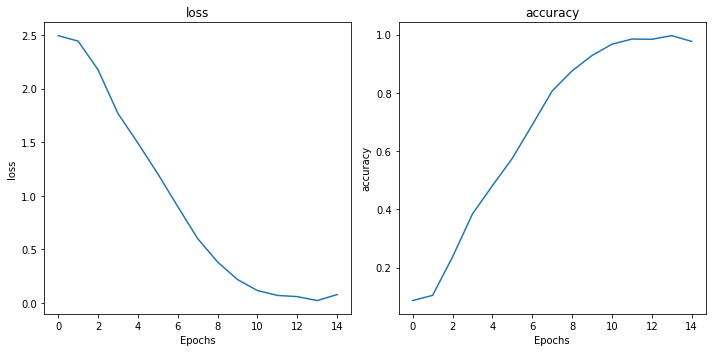

In [19]:
customModel.plot_metrics()

In [20]:
custom_score = customModel.test(custom_test_gen)
customModel.display_score(custom_score)

150/150 [==============================] - 22s 145ms/step - loss: 0.4694 - accuracy: 0.8983
Loss: 0.4693610668182373, Accuracy: 0.8983333110809326


Now, we also are experimenting on some of the pretrained models like VGG, InceptionNet and EfficientNet. We have defined single class `PretrainedModel` below which will take instance of pretrained model and define it as functional unit in the classification model followed by multiple fully connected layers and softmax output.

In [32]:
class PretrainedModel(ModifiedModel):
    def __init__(self,
                 input_shape,
                 num_classes,
                 pretrainedModel,
                 optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'],
                 verbose=True):
        super().__init__(input_shape,
                         num_classes,
                         optimizer,
                         loss,
                         metrics,
                         verbose)
        self.pretrained = pretrainedModel
        self.build_model()
        self.compile_model()
    
    def build_model(self):
        for layer in self.pretrained.layers:
            layer.trainable = False
        self.model = Sequential([
            self.pretrained,
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.num_classes, activation = 'softmax')
        ])

## Transfer Learning on VGG16

We are using pretrained `VGG16` model as the first layer in our model and retraing only the layers which are added. The input images resized to shape `(224, 224, 3)`.

In [60]:
vgg_img_height = 224
vgg_img_width = 224

vgg_train_gen = TissueDataGenerator(train_data_dir,
                                    batch_size=batch_size,
                                    class_labels=tissue_classes,
                                    img_height=vgg_img_height,
                                    img_width=vgg_img_width,
                                    preprocess_func=tf.keras.applications.vgg16.preprocess_input)
vgg_test_gen = TissueDataGenerator(test_data_dir,
                                   batch_size=batch_size,
                                   class_labels=tissue_classes,
                                   img_height=vgg_img_height,
                                   img_width=vgg_img_width,
                                   preprocess_func=tf.keras.applications.vgg16.preprocess_input)

In [61]:
vggModel = PretrainedModel(input_shape=(vgg_img_height, vgg_img_width, num_channels),
                           num_classes=len(tissue_classes),
                           pretrainedModel=tf.keras.applications.vgg16.VGG16())

In [62]:
vggModel.model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
flatten_9 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               512512    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_27 (Dense)             (None, 12)                1548      
Total params: 138,937,268
Trainable params: 579,724
Non-trainable params: 138,357,544
_________________________________________________________________


In [63]:
vggModel.train(vgg_train_gen, epochs=epochs)

Epoch 1/15
279/279 [==============================] - 152s 544ms/step - loss: 2.0408 - accuracy: 0.2879
Epoch 2/15
279/279 [==============================] - 149s 532ms/step - loss: 1.4905 - accuracy: 0.4570
Epoch 3/15
279/279 [==============================] - 140s 500ms/step - loss: 1.3074 - accuracy: 0.5233
Epoch 4/15
279/279 [==============================] - 145s 519ms/step - loss: 1.1825 - accuracy: 0.5753
Epoch 5/15
279/279 [==============================] - 147s 526ms/step - loss: 1.0885 - accuracy: 0.6147
Epoch 6/15
279/279 [==============================] - 146s 522ms/step - loss: 1.0034 - accuracy: 0.6407
Epoch 7/15
279/279 [==============================] - 142s 506ms/step - loss: 0.9177 - accuracy: 0.6828
Epoch 8/15
279/279 [==============================] - 140s 500ms/step - loss: 0.8626 - accuracy: 0.6998
Epoch 9/15
279/279 [==============================] - 143s 510ms/step - loss: 0.7967 - accuracy: 0.7151
Epoch 10/15
279/279 [==============================] - 143s 511m

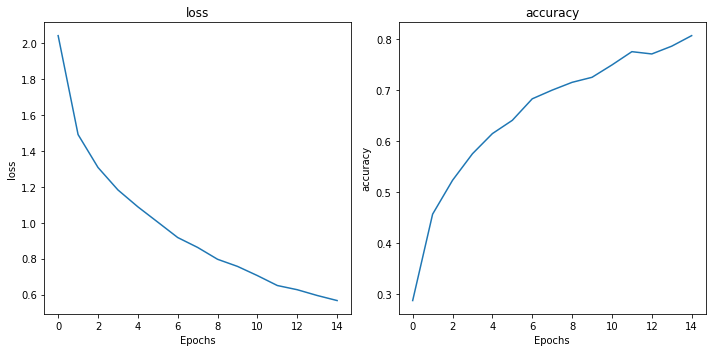

In [64]:
vggModel.plot_metrics()

In [65]:
vgg_score = vggModel.test(vgg_test_gen)
vggModel.display_score(vgg_score)

150/150 [==============================] - 76s 506ms/step - loss: 0.6340 - accuracy: 0.7800
Loss: 0.6340402960777283, Accuracy: 0.7799999713897705


## Transfer Learning on InceptionV3

We are using pretrained `InceptionV3` model as the first layer in our model and retraing only the layers which are added. The input images resized to shape `(299, 299, 3)`.

In [48]:
inception_img_height = 299
inception_img_width = 299

inception_train_gen = TissueDataGenerator(train_data_dir,
                                          batch_size=batch_size,
                                          class_labels=tissue_classes,
                                          img_height=inception_img_height,
                                          img_width=inception_img_width,
                                          preprocess_func=tf.keras.applications.inception_v3.preprocess_input)
inception_test_gen = TissueDataGenerator(test_data_dir,
                                         batch_size=batch_size,
                                         class_labels=tissue_classes,
                                         img_height=inception_img_height,
                                         img_width=inception_img_width,
                                         preprocess_func=tf.keras.applications.inception_v3.preprocess_input)

In [49]:
inceptionModel = PretrainedModel(input_shape=(inception_img_height, inception_img_width, num_channels),
                                 num_classes=len(tissue_classes),
                                 pretrainedModel=tf.keras.applications.inception_v3.InceptionV3())

In [50]:
inceptionModel.model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1000)              23851784  
_________________________________________________________________
flatten_7 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               512512    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_21 (Dense)             (None, 12)                1548      
Total params: 24,431,508
Trainable params: 579,724
Non-trainable params: 23,851,784
_________________________________________________________________


In [51]:
inceptionModel.train(inception_train_gen, epochs=epochs)

Epoch 1/15
279/279 [==============================] - 60s 210ms/step - loss: 2.1231 - accuracy: 0.2807
Epoch 2/15
279/279 [==============================] - 58s 207ms/step - loss: 1.5697 - accuracy: 0.4525
Epoch 3/15
279/279 [==============================] - 58s 209ms/step - loss: 1.3266 - accuracy: 0.5376
Epoch 4/15
279/279 [==============================] - 59s 210ms/step - loss: 1.1773 - accuracy: 0.5762
Epoch 5/15
279/279 [==============================] - 57s 205ms/step - loss: 1.0650 - accuracy: 0.6201
Epoch 6/15
279/279 [==============================] - 58s 207ms/step - loss: 0.9760 - accuracy: 0.6470
Epoch 7/15
279/279 [==============================] - 58s 207ms/step - loss: 0.8936 - accuracy: 0.6694
Epoch 8/15
279/279 [==============================] - 58s 207ms/step - loss: 0.8302 - accuracy: 0.6989
Epoch 9/15
279/279 [==============================] - 58s 207ms/step - loss: 0.7557 - accuracy: 0.7321
Epoch 10/15
279/279 [==============================] - 57s 205ms/step - l

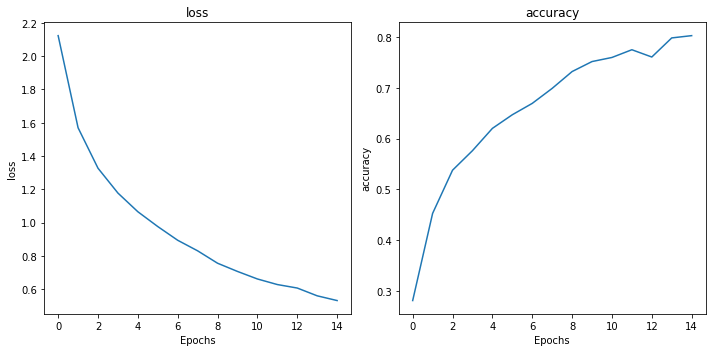

In [52]:
inceptionModel.plot_metrics()

In [53]:
inception_score = inceptionModel.test(inception_test_gen)
inceptionModel.display_score(inception_score)

150/150 [==============================] - 36s 234ms/step - loss: 0.6953 - accuracy: 0.8000
Loss: 0.6953201293945312, Accuracy: 0.800000011920929


## Transfer Learning on EfficientNetB7

We are using pretrained `EfficientNetB7` model as the first layer in our model and retraing only the layers which are added. The input images resized to shape `(128, 128, 3)`.

In [54]:
effnet_img_height = 128
effnet_img_width = 128

effnet_train_gen = TissueDataGenerator(train_data_dir,
                                       batch_size=batch_size,
                                       class_labels=tissue_classes,
                                       img_height=effnet_img_height,
                                       img_width=effnet_img_width,
                                       preprocess_func=tf.keras.applications.efficientnet.preprocess_input)
effnet_test_gen = TissueDataGenerator(test_data_dir,
                                      batch_size=batch_size,
                                      class_labels=tissue_classes,
                                      img_height=effnet_img_height,
                                      img_width=effnet_img_width,
                                      preprocess_func=tf.keras.applications.efficientnet.preprocess_input)

In [55]:
effnetModel = PretrainedModel(input_shape=(effnet_img_height, effnet_img_width, num_channels),
                              num_classes=len(tissue_classes),
                              pretrainedModel=tf.keras.applications.efficientnet.EfficientNetB7())

In [56]:
effnetModel.model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 1000)              66658687  
_________________________________________________________________
flatten_8 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               512512    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_24 (Dense)             (None, 12)                1548      
Total params: 67,238,411
Trainable params: 579,724
Non-trainable params: 66,658,687
_________________________________________________________________


In [57]:
effnetModel.train(effnet_train_gen, epochs=epochs)

Epoch 1/15
279/279 [==============================] - 69s 227ms/step - loss: 2.3579 - accuracy: 0.1695
Epoch 2/15
279/279 [==============================] - 67s 240ms/step - loss: 2.0129 - accuracy: 0.2966
Epoch 3/15
279/279 [==============================] - 65s 233ms/step - loss: 1.8224 - accuracy: 0.3638
Epoch 4/15
279/279 [==============================] - 62s 221ms/step - loss: 1.6979 - accuracy: 0.3970
Epoch 5/15
279/279 [==============================] - 59s 212ms/step - loss: 1.6255 - accuracy: 0.4409
Epoch 6/15
279/279 [==============================] - 59s 210ms/step - loss: 1.5655 - accuracy: 0.4516
Epoch 7/15
279/279 [==============================] - 58s 207ms/step - loss: 1.5111 - accuracy: 0.4588
Epoch 8/15
279/279 [==============================] - 56s 202ms/step - loss: 1.4615 - accuracy: 0.4928
Epoch 9/15
279/279 [==============================] - 54s 195ms/step - loss: 1.4416 - accuracy: 0.4884
Epoch 10/15
279/279 [==============================] - 55s 198ms/step - l

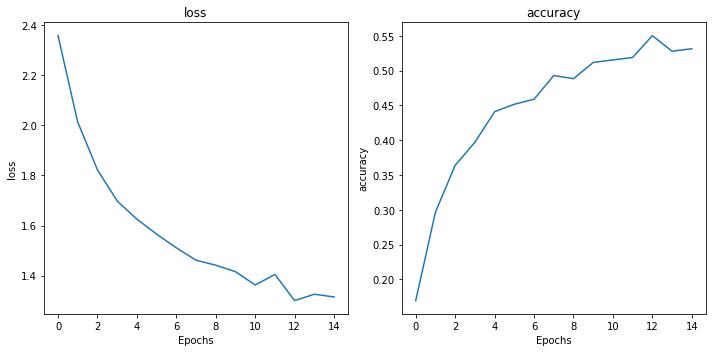

In [58]:
effnetModel.plot_metrics()

In [59]:
effnet_score = effnetModel.test(effnet_test_gen)
effnetModel.display_score(effnet_score)

150/150 [==============================] - 38s 239ms/step - loss: 1.2247 - accuracy: 0.6017
Loss: 1.2247464656829834, Accuracy: 0.6016666889190674


Note that above three pretrained model accuracy will improve on training for more epochs but we were not able to do that because of less computational power and time constraint.

## t-SNE plot for visualizing data distributions

We can see from above training that our custom generated model works better than pretrained models for this dataset. So, for drawing features from data, we will use `customModel`.

In [122]:
img_height = 128
img_width = 128

model = customModel
label2int = {}
for i, t in enumerate(tissue_classes):
    label2int[t] = i

def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    label_map = label2int[str(label.numpy().decode('utf-8'))]
    image = np.array(PIL.Image.open(str(file_path.numpy().decode('utf-8'))))
    image = tf.image.resize(image, (img_height, img_width))
    feature = model.model(np.array([image]))
    return feature.numpy()[0], label_map

train_gen = TissueDataGenerator(train_data_dir,
                                batch_size=batch_size,
                                class_labels=tissue_classes,
                                img_height=img_height,
                                img_width=img_width)
train_ds = train_gen.file_ds.map(lambda f: tf.py_function(func=process_path,
                                                          inp=[f],
                                                          Tout=[tf.float32, tf.int32]))

test_gen = TissueDataGenerator(test_data_dir,
                               batch_size=batch_size,
                               class_labels=tissue_classes,
                               img_height=img_height,
                               img_width=img_width)
test_ds = test_gen.file_ds.map(lambda f: tf.py_function(func=process_path,
                                                        inp=[f],
                                                        Tout=[tf.float32, tf.int32]))

In [123]:
def extract_data(ds):
    images = None
    labels = None
    for img, lab in tqdm(ds):
        if images is None:
            images = np.array([img])
            labels = np.array([lab])
        else:
            images = np.append(images, [img], axis=0)
            labels = np.append(labels, [lab], axis=0)
    return images, labels

train_images, train_labels = extract_data(train_ds)
test_images, test_labels = extract_data(test_ds)

100%|█████████████████████████████████████████| 600/600 [00:23<00:00, 25.43it/s]


In [135]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [132]:
train_tsne = TSNE(n_components=2, random_state=41).fit_transform(train_images)
test_tsne = TSNE(n_components=2, random_state=41).fit_transform(test_images)

/Users/ashutosh1919/miniforge3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ashutosh1919/miniforge3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ashutosh1919/miniforge3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ashutosh1919/miniforge3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [138]:
def tissue_scatter(x, colors):
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-4.128545, 21.993654, '0'),
  Text(1.5386072, -44.045876, '1'),
  Text(23.082092, 2.5283957, '2'),
  Text(51.30031, 7.4893274, '3'),
  Text(-11.868339, 41.06844, '4'),
  Text(-18.559313, -12.289486, '5'),
  Text(-1.3918827, 4.0964575, '6'),
  Text(20.737919, 33.916122, '7'),
  Text(-14.691046, 20.417854, '8'),
  Text(-44.478214, 3.492125, '9'),
  Text(-27.710861, -40.101128, '10'),
  Text(28.459045, -24.704403, '11')])

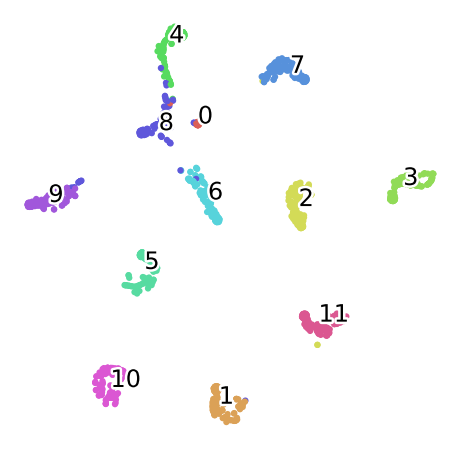

In [139]:
tissue_scatter(train_tsne, train_labels)

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(0.7417629, 9.912537, '0'),
  Text(38.876263, -1.2204735, '1'),
  Text(11.41721, -40.72262, '2'),
  Text(-3.9218192, -13.401983, '3'),
  Text(12.401884, 7.8404207, '4'),
  Text(16.854078, -15.387412, '5'),
  Text(6.4725485, 25.637566, '6'),
  Text(-23.660654, -3.490017, '7'),
  Text(0.14200279, 18.296053, '8'),
  Text(-11.60443, 23.5574, '9'),
  Text(-11.514649, -35.097923, '10'),
  Text(-40.80126, 13.169273, '11')])

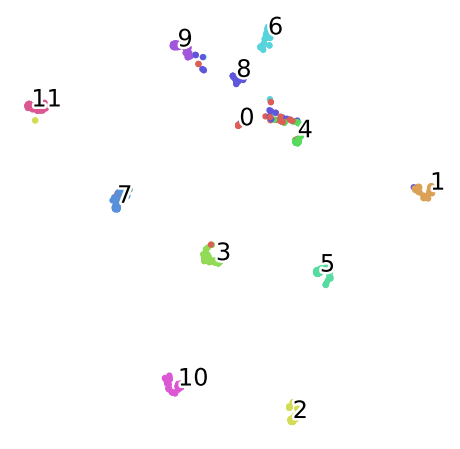

In [141]:
tissue_scatter(test_tsne, test_labels)